In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

def load_test_images():
    images = []
    
    test_images = glob.glob('test_images/*.jpg')
    
    for idx, fname in enumerate(test_images):
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        images.append(img)
        
    problematic_images = glob.glob('problematic/*.jpg')
    
    for idx, fname in enumerate(problematic_images):
        img = cv2.imread(fname)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        images.append(img)
    
    return images

In [2]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [3]:
def convert_color_space(image, target_color_space='RGB'):
        if target_color_space != 'RGB':
            if target_color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif target_color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif target_color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif target_color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif target_color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
            
        return feature_image

In [4]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color2))

In [5]:
def color_hist(img, nbins=32, hrange=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=hrange)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=hrange)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=hrange)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [6]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [7]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),
                        orientation=9, pixels_per_cell=8, cell_per_block=2):
    # Create a list to append feature vectors to
    features = []
    
    for iname in imgs:
        img = cv2.imread(iname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img_converted = convert_color_space(img, cspace)
        
        f_bin = bin_spatial(img_converted, spatial_size)
        f_hist = color_hist(img_converted, hist_bins, hist_range)
        f_hog_0 = get_hog_features(img_converted[:,:,0], orientation, pixels_per_cell, cell_per_block, vis=False)
        f_hog_1 = get_hog_features(img_converted[:,:,1], orientation, pixels_per_cell, cell_per_block, vis=False)
        f_hog_2 = get_hog_features(img_converted[:,:,2], orientation, pixels_per_cell, cell_per_block, vis=False)
        
        features.append(np.concatenate((f_bin, f_hist, f_hog_0, f_hog_1, f_hog_2)))
    
    return features

In [75]:
def add_heat(heatmap, bbox_list, previous_frames=None):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    # Iterate through list of previuos frames
    if previous_frames is not None:
        previous_frames.reverse()

        weight = 0.9
        for frame in previous_frames:
            for box in frame:
                # Add += weight for all pixels inside each bbox
                # Assuming each "box" takes the form ((x1, y1), (x2, y2))
                heatmap[int(box[0][1]):int(box[1][1]), int(box[0][0]):int(box[1][0])] += weight
            weight = weight - 0.1
            if weight < 0.0:
                break

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [9]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [10]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    
    boxes = []
    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        box_size = (bbox[1][0] - bbox[0][0]) * (bbox[1][1] - bbox[0][1])
        
        if (box_size > 2000):
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            boxes.append(bbox)
        
        #print("Box size: " + str())
        
    # Return the image
    return img, boxes

Train classifier

In [11]:
# Parameters
ystart = 400
ystop = 650

orientation = 9
pixels_per_cell = 8
cell_per_block = 2
spatial_size = (16, 16)
hist_bins = 16
hist_range=(0, 256)
colorspace = 'YUV' # 'YCrCb', 'YUV'

In [12]:
import time

cars = glob.glob('vehicles/**/*.png', recursive=True)
non_cars = glob.glob('non-vehicles/**/*.png', recursive=True)

#TODO: remove this
#from random import shuffle
#shuffle(cars)
#shuffle(non_cars)
#sample_size = 1000
#cars = cars[0:sample_size]
#non_cars = non_cars[0:sample_size]
#TODO end

t0=time.time()
car_features = extract_features(cars, colorspace, spatial_size,
                        hist_bins, hist_range,
                        orientation, pixels_per_cell, cell_per_block)
t1=time.time()
non_car_features = extract_features(non_cars, colorspace, spatial_size,
                        hist_bins, hist_range,
                        orientation, pixels_per_cell, cell_per_block)
t2=time.time()
print(round(t2-t0, 2), 'Seconds to extract features...')

/Users/marcin/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


125.2 Seconds to extract features...


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = np.vstack((car_features, non_car_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [14]:
from sklearn.svm import LinearSVC

# Use a linear SVC 
svc = LinearSVC(C=1.0) #LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

15.03 Seconds to train SVC...


In [15]:
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9916


In [16]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color_space(img_tosearch, cspace)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, hist_bins, hist_range)

            #np.concatenate((spatial_features ,hist_features, hog_feat1, hog_feat2, hog_feat3))
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, bboxes

In [18]:
import asyncio
import concurrent

def get_car_boxes(img):
    t0=time.time()
    
    executor = concurrent.futures.ProcessPoolExecutor(5)
    
    bboxes = []
    
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)  
    
    #f1 = loop.run_in_executor(executor, find_cars, img, ystart, ystop, 0.75, svc, X_scaler, orientation, pixels_per_cell, cell_per_block, spatial_size, hist_bins, colorspace)
    f2 = loop.run_in_executor(executor, find_cars, img, ystart, ystop, 1.0, svc, X_scaler, orientation, pixels_per_cell, cell_per_block, spatial_size, hist_bins, colorspace)
    f3 = loop.run_in_executor(executor, find_cars, img, ystart, ystop, 1.25, svc, X_scaler, orientation, pixels_per_cell, cell_per_block, spatial_size, hist_bins, colorspace)
    f4 = loop.run_in_executor(executor, find_cars, img, ystart, ystop, 1.5, svc, X_scaler, orientation, pixels_per_cell, cell_per_block, spatial_size, hist_bins, colorspace)
    f5 = loop.run_in_executor(executor, find_cars, img, ystart, ystop, 2.0, svc, X_scaler, orientation, pixels_per_cell, cell_per_block, spatial_size, hist_bins, colorspace)
    
    r2, r3, r4, r5 = loop.run_until_complete(asyncio.gather(f2, f3, f4, f5))
    executor.shutdown(wait=True)
    loop.close()
    
    bboxes = bboxes + r2[1] + r3[1] + r4[1] + r5[1]

    
    t2=time.time()
    #print(round(t2-t0, 2), 'Seconds to get boxes...')
    
    return bboxes, (r2[1], r3[1], r4[1], r5[1])

In [76]:
from scipy.ndimage.measurements import label

def process_image(img, previous_boxes=None, boxes_data=None, heat_thresh=3):
    
    #img_converted = convert_color_space(img, 'HSV')
    
    #channel = 2
    
    #features, hog_image = get_hog_features(img_converted[:,:,channel], orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    
    #t0=time.time()
    #bboxes = []
    
    #result_1, bboxes_1 = find_cars(img, ystart, ystop, 0.5, svc, X_scaler, orientation, pixels_per_cell, cell_per_block, spatial_size, hist_bins, colorspace)
    #result_2, bboxes_2 = find_cars(img, ystart, ystop, 0.75, svc, X_scaler, orientation, pixels_per_cell, cell_per_block, spatial_size, hist_bins, colorspace)
    #result_3, bboxes_3 = find_cars(img, ystart, ystop, 1.0, svc, X_scaler, orientation, pixels_per_cell, cell_per_block, spatial_size, hist_bins, colorspace)
    #result_4, bboxes_4 = find_cars(img, ystart, ystop, 1.5, svc, X_scaler, orientation, pixels_per_cell, cell_per_block, spatial_size, hist_bins, colorspace)
    #result_5, bboxes_5 = find_cars(img, ystart, ystop, 2.0, svc, X_scaler, orientation, pixels_per_cell, cell_per_block, spatial_size, hist_bins, colorspace)
    
    #bboxes = bboxes + bboxes_3 + bboxes_4 + bboxes_5
    
    #t2=time.time()
    #print(round(t2-t0, 2), 'Seconds to get boxes old way...')
    
    bboxes, boxes_raw = get_car_boxes(img)
    
    if boxes_data is not None:
        boxes_data.append(boxes_raw)
    
    #binary_output = np.zeros_like(hog_image)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    #binary_output[(hog_image > 1.0)] = 1
    
    #result = hog_image
    
    previous_boxes_list = None
    
    if previous_boxes is not None:
        previous_boxes_list = previous_boxes[-9:] # last 9 frames
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bboxes, previous_boxes_list)
    heat = apply_threshold(heat, heat_thresh) # 3 if without 1.25 scale
    # threshold for the size (area)
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    
    result, pboxes = draw_labeled_bboxes(np.copy(img), labels)
    
    if previous_boxes is not None:
        previous_boxes.append(bboxes)
    
    return result

In [77]:
images = load_test_images()

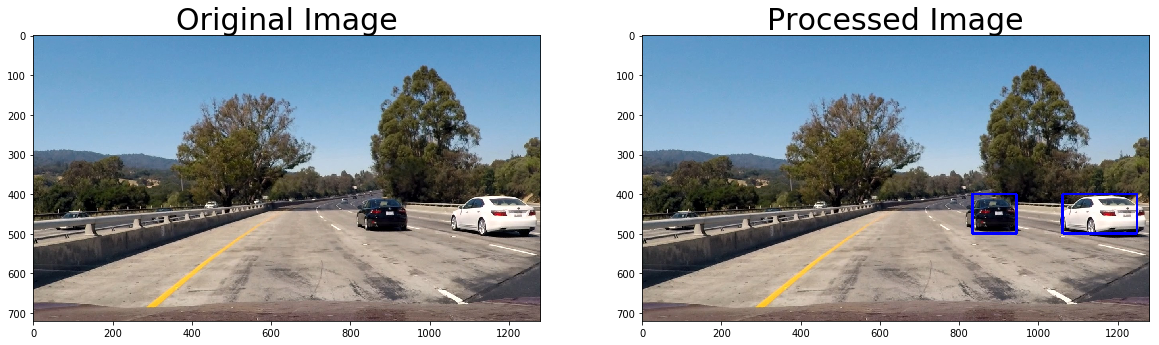

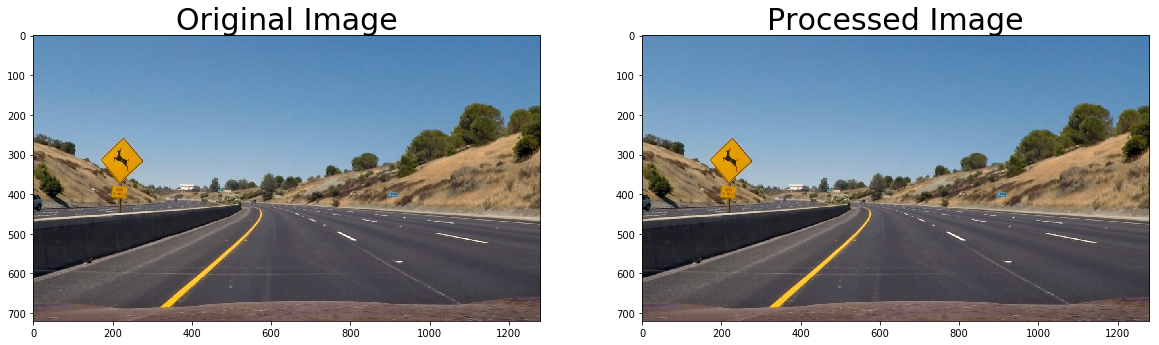

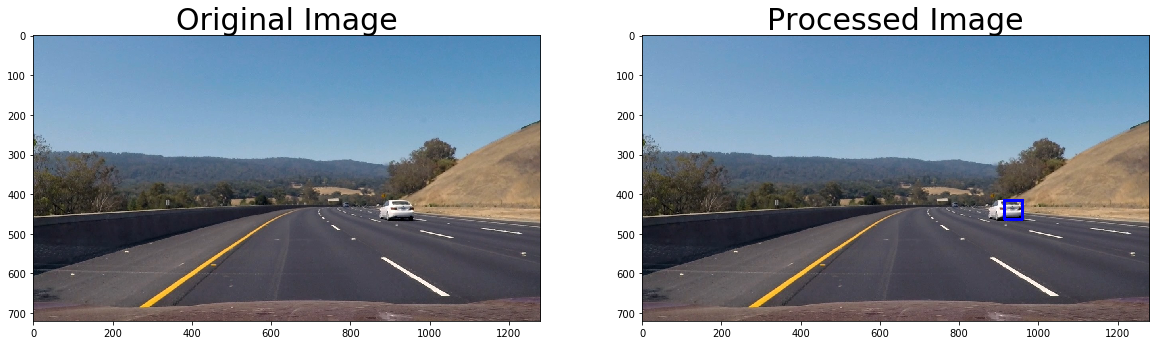

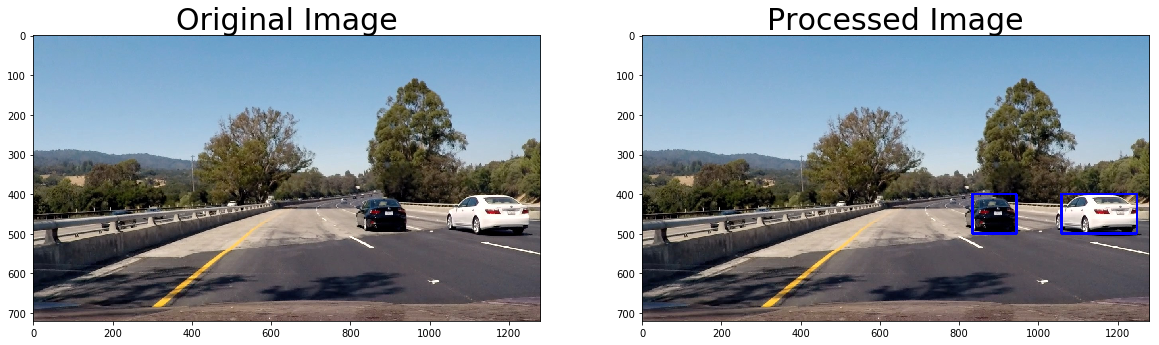

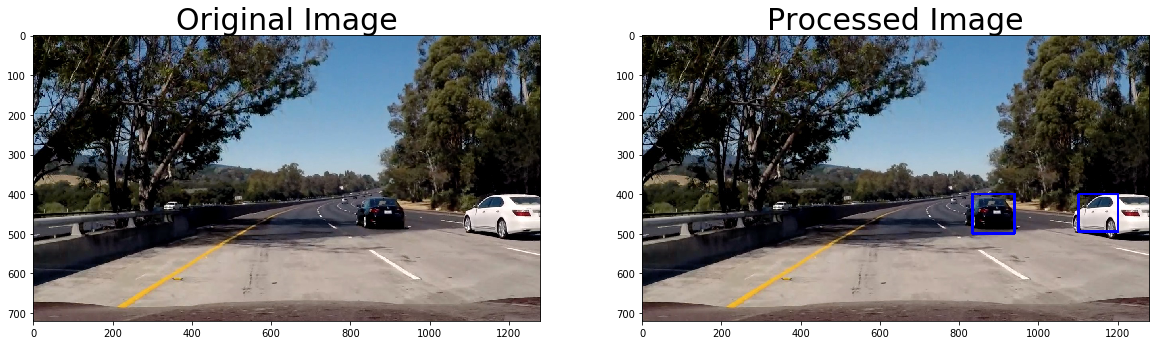

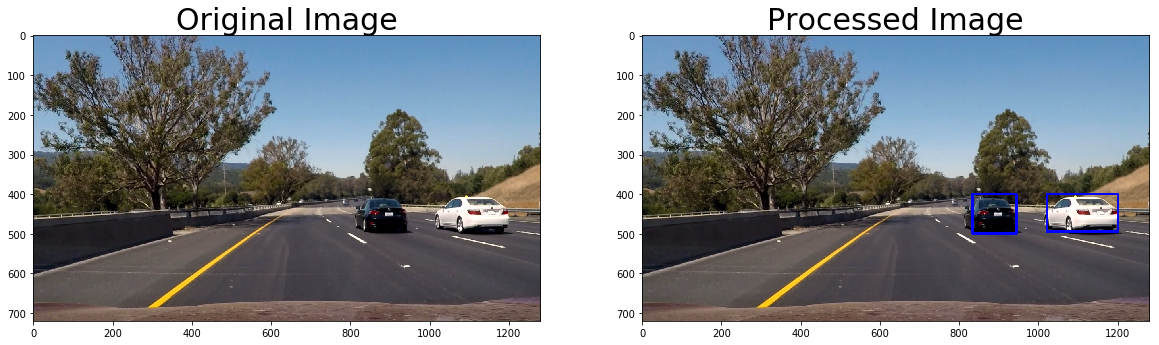

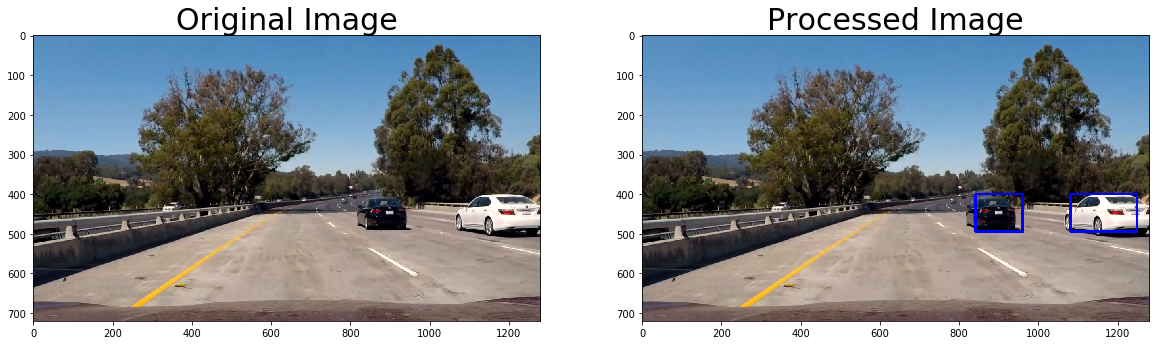

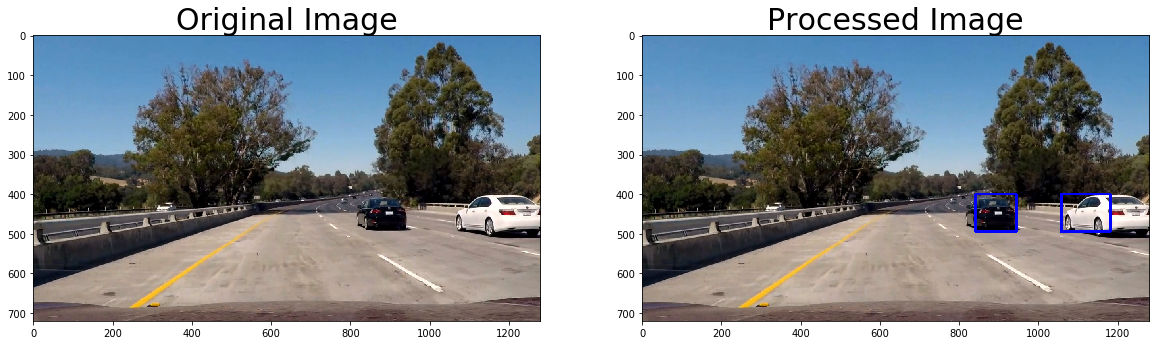

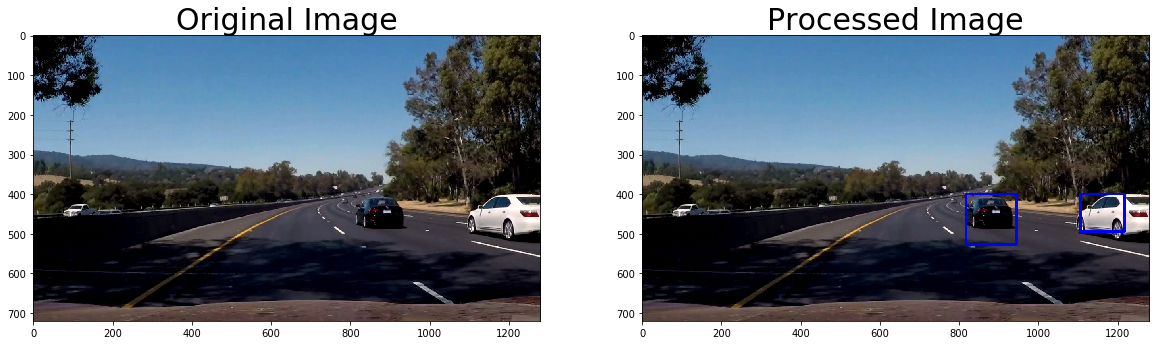

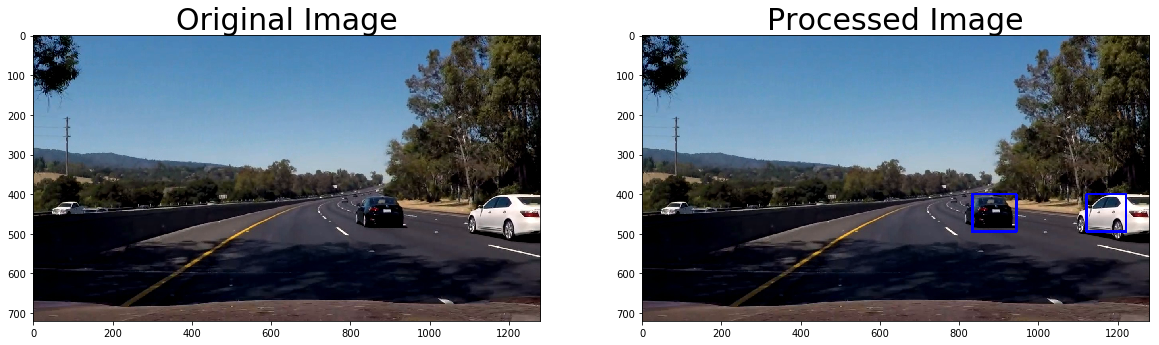

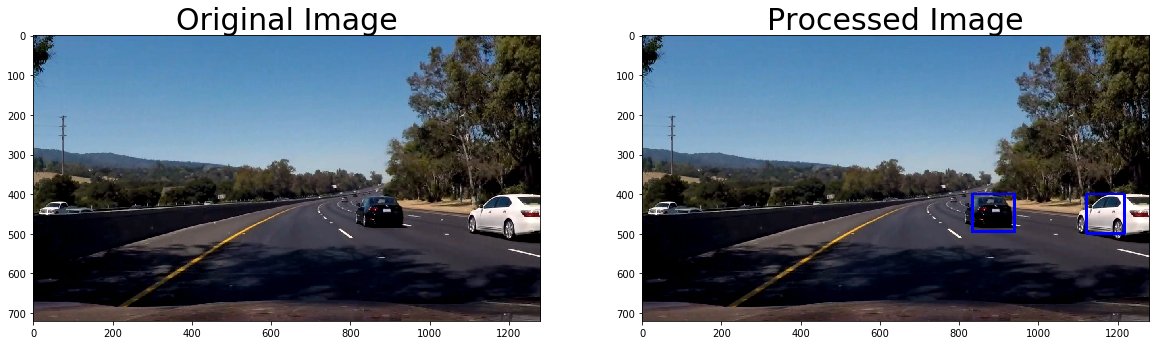

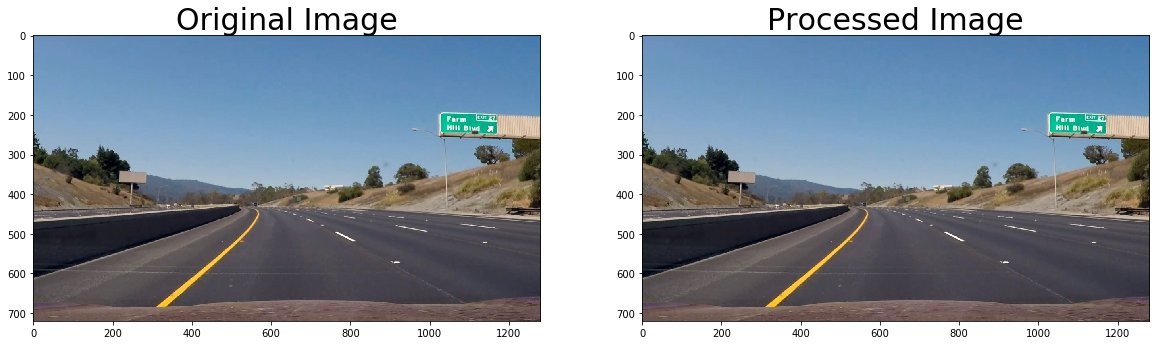

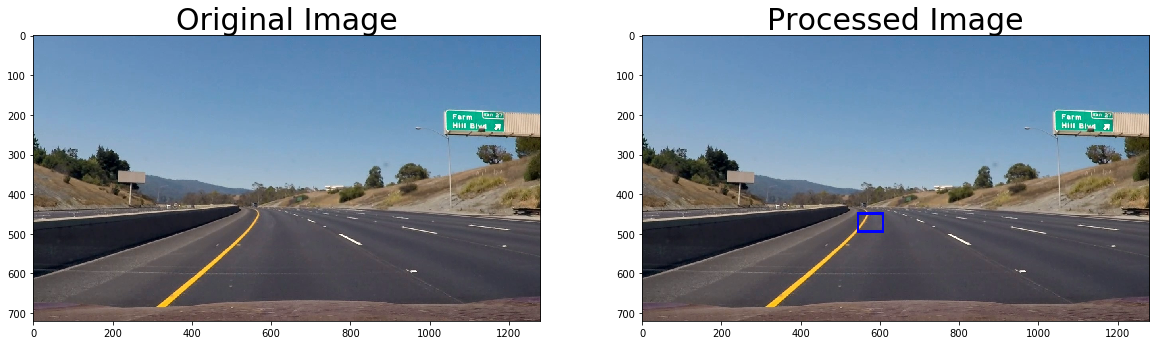

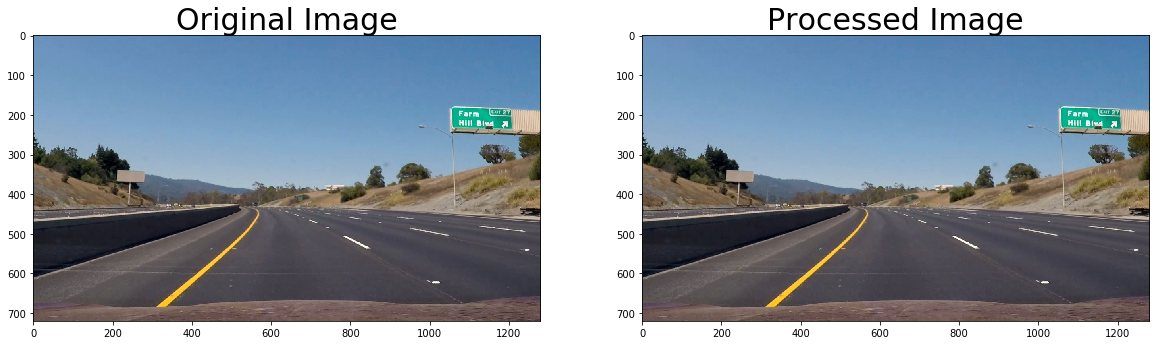

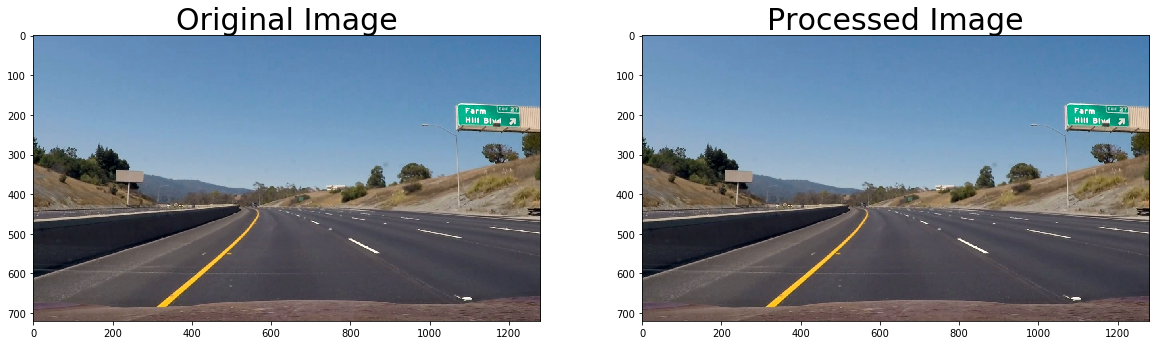

In [78]:
import matplotlib.pyplot as plt

for img in images:
    processed = process_image(img, heat_thresh=3)
    
    # Visualize                      
    %matplotlib inline
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(processed, cmap='gray')
    ax2.set_title('Processed Image', fontsize=30)
    plt.show()
    


In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [85]:
previous_boxes = []
raw_boxes = []
idx = 0
def process_images_smooth(img):
    global idx
    #cv2.imwrite('frames/frame_{}.jpg'.format(idx), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    idx = idx + 1
    return process_image(img, previous_boxes, raw_boxes, 8)

In [79]:
def process_image_from_list(img, all_boxes, previous_boxes, index, heat_thresh=3):
    
    frame_boxes = all_boxes[index]
    
    bboxes = []
    
    bboxes = bboxes + frame_boxes[0] + frame_boxes[1] + frame_boxes[2] + frame_boxes[3]
    
    #binary_output = np.zeros_like(hog_image)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    #binary_output[(hog_image > 1.0)] = 1
    
    #result = hog_image
    
    previous_frames = all_boxes[index-9:index] # last 9 frames
    
    flatten = []
    
    for pf in previous_frames:
        flatten.append([] + pf[0] + pf[1] + pf[2] + pf[3])
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bboxes, flatten)
    heat = apply_threshold(heat, heat_thresh) # 3 if without 1.25 scale
    # threshold for the size (area)
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    
    result, pboxes = draw_labeled_bboxes(np.copy(img), labels)
    
    if previous_boxes is not None:
        previous_boxes.append(pboxes)
    
    return result

In [80]:
idx = 0
p_boxes = []
def process_images_from_pickle(img):
    global idx
    #cv2.imwrite('frames/frame_{}.jpg'.format(idx), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    img = process_image_from_list(img, raw_boxes, p_boxes, idx, heat_thresh=10)
    idx = idx + 1
    return img

In [87]:
output = 'project_video_processed.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,15)
clip1 = VideoFileClip("project_video.mp4").subclip(25,32)
white_clip = clip1.fl_image(process_images_smooth) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4



 88%|████████▊ | 155/176 [05:43<00:45,  2.17s/it]


 99%|█████████▉| 175/176 [06:26<00:02,  2.15s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 10.2 s, sys: 15.5 s, total: 25.7 s
Wall time: 6min 28s


In [25]:
import pickle
with open('raw_boxes.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(raw_boxes, f, pickle.HIGHEST_PROTOCOL)

In [54]:
len(raw_boxes)

1261

In [26]:
raw_boxes[0]

([((880, 416), (944, 480)),
  ((896, 416), (960, 480)),
  ((960, 416), (1024, 480)),
  ((976, 416), (1040, 480)),
  ((976, 432), (1040, 496))],
 [((816, 400), (912, 496)),
  ((816, 424), (912, 520)),
  ((840, 400), (936, 496)),
  ((960, 400), (1056, 496)),
  ((984, 400), (1080, 496)),
  ((1008, 400), (1104, 496)),
  ((1032, 400), (1128, 496))],
 [((800, 400), (928, 528)), ((832, 400), (960, 528))],
 [((840, 400), (920, 480)),
  ((860, 420), (940, 500)),
  ((960, 400), (1040, 480)),
  ((1000, 400), (1080, 480)),
  ((1020, 400), (1100, 480)),
  ((1020, 420), (1100, 500)),
  ((1040, 400), (1120, 480)),
  ((1040, 420), (1120, 500)),
  ((1060, 420), (1140, 500))])

In [27]:
with open('raw_boxes.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    qqq = pickle.load(f)

In [28]:
len(qqq)

1261

In [41]:
def play_with_parameters(orient, pix, cells):
    
    cspace = 'YUV'
    
    img_car = cv2.imread(cars[1])
    img_car = cv2.cvtColor(img_car, cv2.COLOR_BGR2RGB)
    img_car_converted = convert_color_space(img_car, cspace)
    img_non_car = cv2.imread('problematic/non_car.png')
    img_non_car = cv2.cvtColor(img_non_car, cv2.COLOR_BGR2RGB)
    img_non_car_converted = convert_color_space(img_non_car, cspace)
    
    f_hog_car_0, img_hog_car_0 = get_hog_features(img_car_converted[:,:,0], orient, pix, cells, vis=True)
    f_hog_car_1, img_hog_car_1 = get_hog_features(img_car_converted[:,:,1], orient, pix, cells, vis=True)
    f_hog_car_2, img_hog_car_2 = get_hog_features(img_car_converted[:,:,2], orient, pix, cells, vis=True)

    f_hog_non_car_0, img_hog_non_car_0 = get_hog_features(img_non_car_converted[:,:,0], orient, pix, cells, vis=True)
    f_hog_non_car_1, img_hog_non_car_1 = get_hog_features(img_non_car_converted[:,:,1], orient, pix, cells, vis=True)
    f_hog_non_car_2, img_hog_non_car_2 = get_hog_features(img_non_car_converted[:,:,2], orient, pix, cells, vis=True)

    
    # Visualize                      
    %matplotlib inline
    f, (ax1, ax2, ax3) = plt.subplots(3, 4, figsize=(30,20))
    ax1[0].imshow(img_car_converted[:,:,0], cmap='gray')
    ax1[0].set_title('Car Ch 1', fontsize=30)
    ax1[1].imshow(img_hog_car_0)
    ax1[1].set_title('HOG Car Ch 1', fontsize=30)
    ax1[2].imshow(img_non_car_converted[:,:,0], cmap='gray')
    ax1[2].set_title('Non-car Ch 1', fontsize=30)
    ax1[3].imshow(img_hog_non_car_0)
    ax1[3].set_title('HOG Non-car Ch 1', fontsize=30)
    
    ax2[0].imshow(img_car_converted[:,:,1], cmap='gray')
    ax2[0].set_title('Car Ch 2', fontsize=30)
    ax2[1].imshow(img_hog_car_1)
    ax2[1].set_title('HOG Car Ch 2', fontsize=30)
    ax2[2].imshow(img_non_car_converted[:,:,1], cmap='gray')
    ax2[2].set_title('Non-car Ch 2', fontsize=30)
    ax2[3].imshow(img_hog_non_car_1)
    ax2[3].set_title('HOG Non-car Ch 2', fontsize=30)
    
    ax3[0].imshow(img_car_converted[:,:,2], cmap='gray')
    ax3[0].set_title('Car Ch 3', fontsize=30)
    ax3[1].imshow(img_hog_car_2)
    ax3[1].set_title('HOG Car Ch 3', fontsize=30)
    ax3[2].imshow(img_non_car_converted[:,:,2], cmap='gray')
    ax3[2].set_title('Non-car Ch 3', fontsize=30)
    ax3[3].imshow(img_hog_non_car_2)
    ax3[3].set_title('HOG Non-car Ch 3', fontsize=30)

    plt.show()

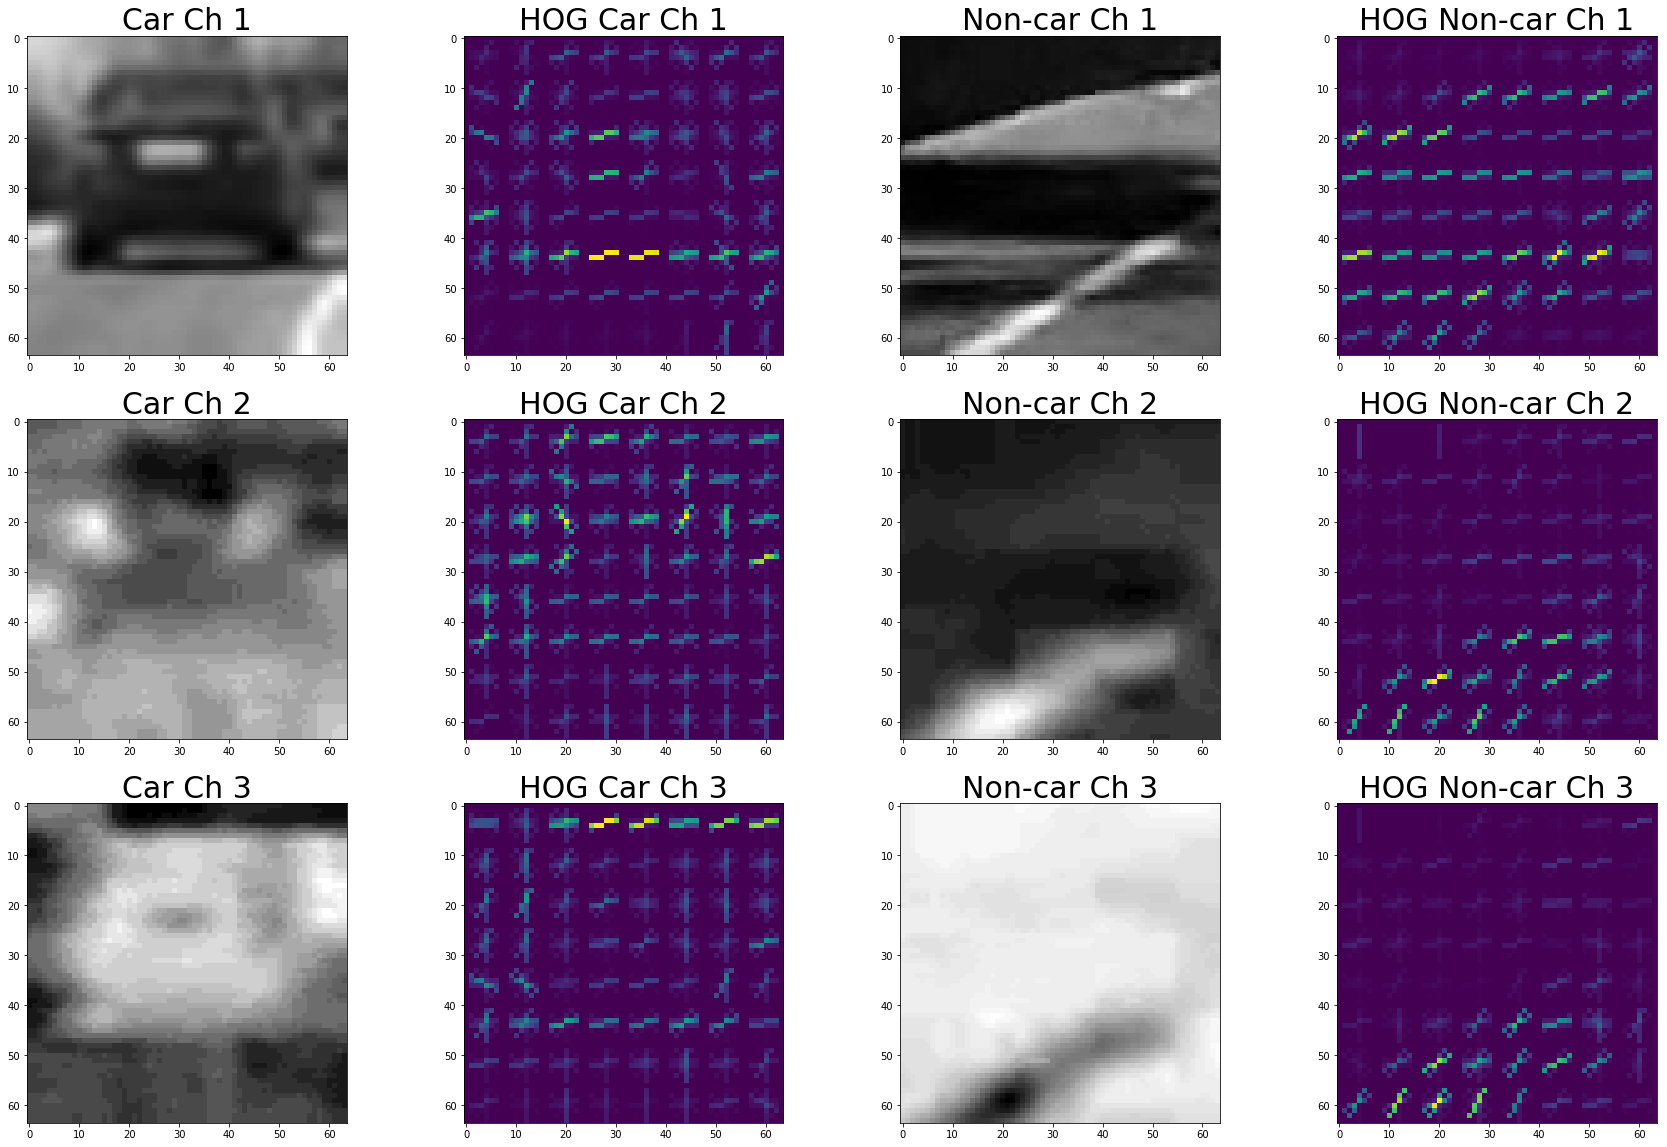

In [42]:
play_with_parameters(9, 8, 2)

In [29]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

/Users/marcin/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


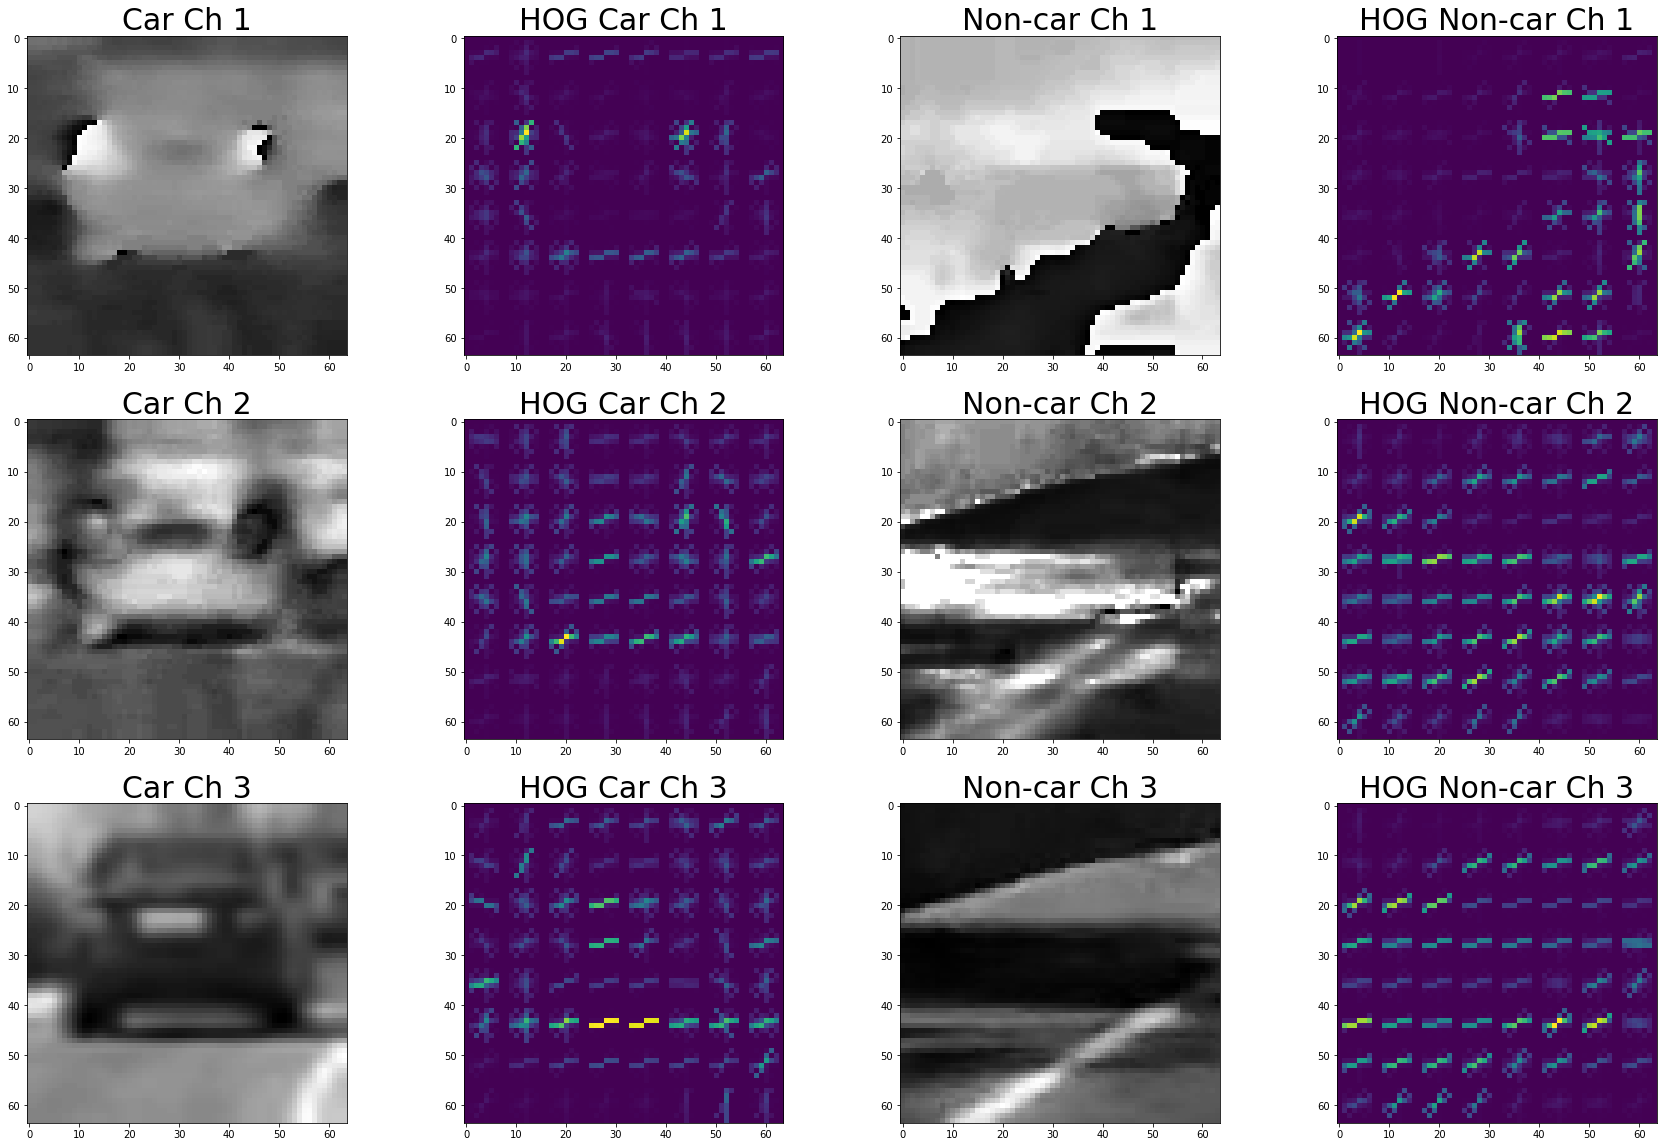

In [30]:
interact(play_with_parameters, orient=(6,24), pix=(2,16), cells=(1,8))

In [28]:
def show_images():    
    # Visualize                      
    %matplotlib inline
    
    img_car = cv2.imread(cars[1])
    img_car = cv2.cvtColor(img_car, cv2.COLOR_BGR2RGB)

    img_non_car = cv2.imread('problematic/non_car.png')
    img_non_car = cv2.cvtColor(img_non_car, cv2.COLOR_BGR2RGB)

    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img_car)
    ax1.set_title('Car', fontsize=30)
    ax2.imshow(img_non_car, cmap='gray')
    ax2.set_title('Non-Car', fontsize=30)
    plt.show()

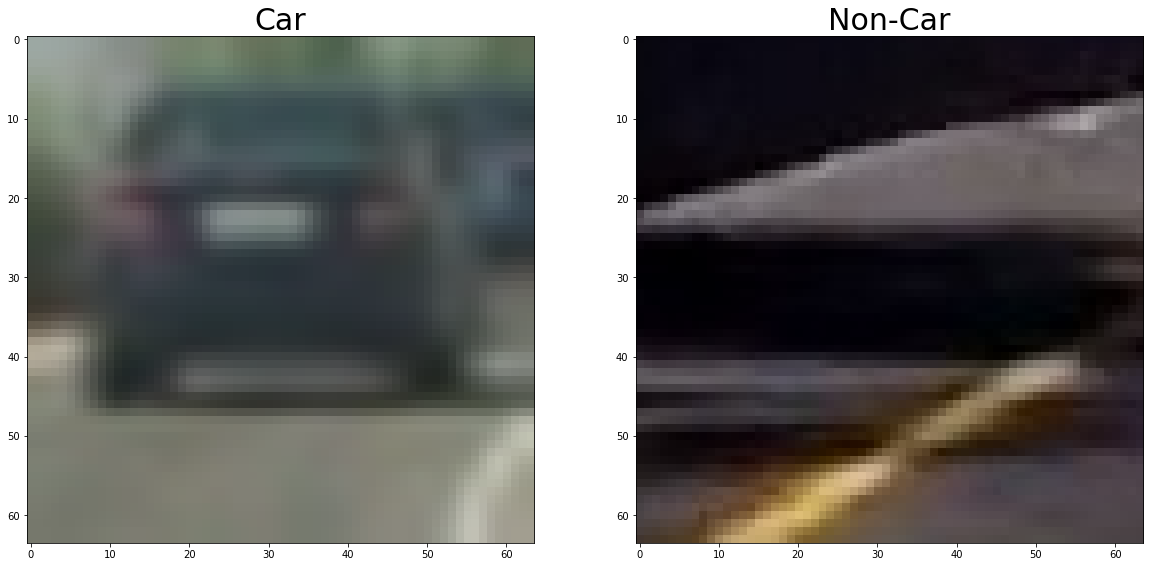

In [29]:
show_images()